#COMS4995 Project

##Step1: Fetch data
mouting data from Google drive and preprocess and store in npy file.

In [0]:
!apt-get install openslide-tools
!pip install openslide-python
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 7 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 0s (1,097 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 130824 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

In [0]:
import re
name_list = os.listdir("/content/gdrive/My Drive/tslide")

In [0]:
# get name list of training slides
mask_list = []
slide_list = []
for name in name_list:
    if re.match('Copy of tumor_[0-9]*\.tif', name):
      slide_list.append(name[:-4])
slide_list.remove("Copy of tumor_038")
print(slide_list)

['Copy of tumor_001', 'Copy of tumor_016', 'Copy of tumor_002', 'Copy of tumor_005', 'Copy of tumor_012', 'Copy of tumor_023', 'Copy of tumor_031', 'Copy of tumor_019', 'Copy of tumor_035', 'Copy of tumor_064', 'Copy of tumor_059', 'Copy of tumor_078', 'Copy of tumor_057', 'Copy of tumor_075', 'Copy of tumor_081', 'Copy of tumor_091', 'Copy of tumor_094', 'Copy of tumor_084', 'Copy of tumor_096', 'Copy of tumor_101', 'Copy of tumor_110']


In [0]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    #print(image.shape)
    im_gray = rgb2gray(image)
    #print(im_gray.shape)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    #print(indices)
    return zip(indices[0], indices[1])

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

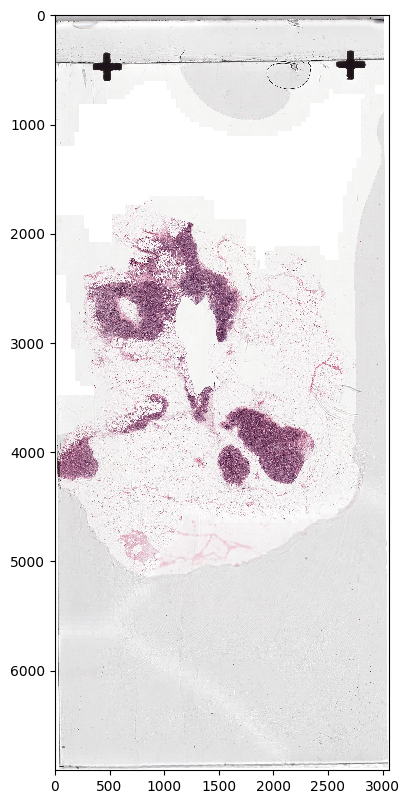

In [0]:
#get data and store slides in list

slides = []
tumor_masks = []
for slide in slide_list:    
    slide_path = slide+'.tif'
    tumor_mask_path = slide+'_mask.tif'
    slide_url = '/content/gdrive/My Drive/tslide/%s' % slide_path
    mask_url = '/content/gdrive/My Drive/tslide/%s' % tumor_mask_path

    slides.append(open_slide(slide_url))
    tumor_masks.append(open_slide(mask_url))

#showing example slide
slide_image = read_slide(slides[0], 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slides[0].level_dimensions[5][0], 
                         height=slides[0].level_dimensions[5][1])
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

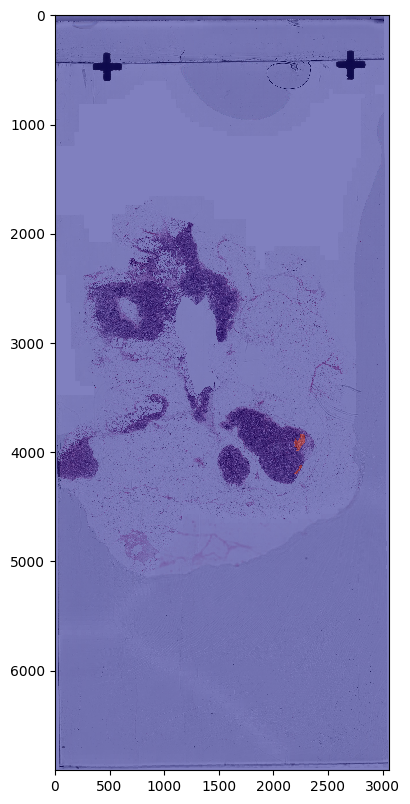

In [0]:
mask_image = read_slide(tumor_masks[0], 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=tumor_masks[0].level_dimensions[5][0], 
                         height=tumor_masks[0].level_dimensions[5][1])
mask_image = mask_image[:,:,0]
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5)

True


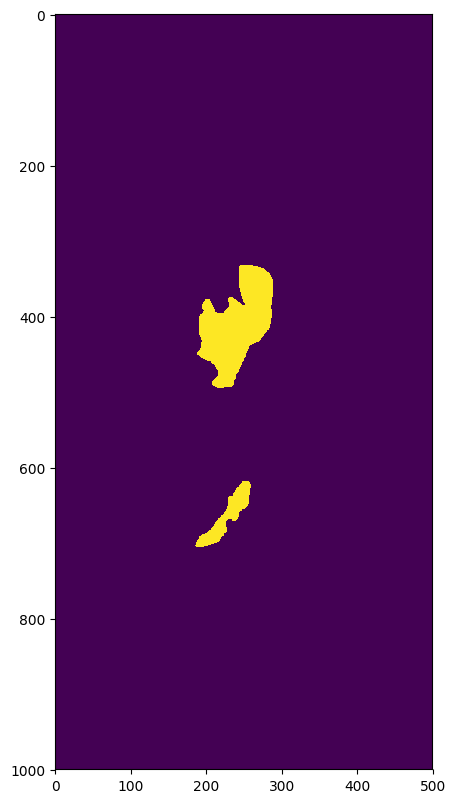

In [0]:
# experiment to get patch from specific location on slide
mask_image = read_slide(tumor_masks[0], 
                         x=2000*32, 
                         y=3500*32, 
                         level=5, 
                         width=500, 
                         height=1000)
mask_image = mask_image[:,:,0]
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

# test function to determine if certain patch contains tumor
def isTumor(mask_region):
  return 1 in mask_region
print(isTumor(mask_image))

In [0]:
# slide metadata on level 4 which is our basic level
print ("Read WSI with base level:%d, max width: %d, max height: %d" % (4,slides[0].level_dimensions[5][0], 
                                                        slides[0].level_dimensions[5][1]))

Read WSI with base level:4, max width: 3056, max height: 6912


1989652
1989652 tissue_pixels pixels (4.2 percent of the image)


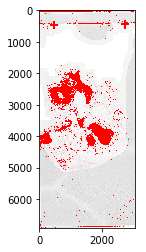

In [0]:
#showing valid tissue pixels of example images
          
tissue_pixels = find_tissue_pixels(slide_image)
size = len(list(tissue_pixels))
tissue_pixels = find_tissue_pixels(slide_image)
tissue_regions = apply_mask(slide_image, tissue_pixels)
print(size)
percent_tissue = size / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (size, percent_tissue)) 
plt.imshow(tissue_regions)

##Step2: Data preprocessing and preparation

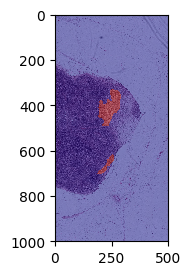

In [0]:
def extract_patch(slide, center_x, center_y, current_level, width, height):
    new_x = int((center_x - width/2 ) * (2**current_level))
    new_y = int((center_y - height/2) * (2**current_level))
    return read_slide(slide, 
                         x = new_x, 
                         y = new_y, 
                         level = current_level, 
                         width = width, 
                         height = height)

mask_image = read_slide(tumor_masks[0], 
                         x=2000*32, 
                         y=3500*32, 
                         level=5, 
                         width=500, 
                         height=1000)

ex_patch = extract_patch(slides[0], 2250, 4000, 5, 500, 1000)
ex_patch_mask = extract_patch(tumor_masks[0], 2250,4000, 5, 500, 1000)[:,:,0]
plt.figure(figsize=(3, 3), dpi=100)
plt.imshow(ex_patch)
plt.imshow(ex_patch_mask, cmap='jet', alpha=0.5)

In [0]:
#set parameters and preprocess patch from two levels
import random
patch_size = 299
threshold = 0.3*299*299
central_size = 128
stride = 100
base_level = 4

normal_patch = []
normal_mask_patch = []
tumor_patch = []
tumor_mask_patch = []
second_level_normal = []
second_level_tumor = []


  #patch is tumor if it containes at least one cancerous cell
def isTumor(mask_region):
  return 1 in mask_region

for k in range(len(slides)):
  for i in range(patch_size+1,slides[k].level_dimensions[4][0]-patch_size, stride): 
    for j in range(patch_size+1,slides[k].level_dimensions[4][1]-patch_size,stride):
      curr_patch = extract_patch(slides[k], i, j, base_level, patch_size, patch_size)
      #find ratio of tissue region to discard invalid patch
      tissue_pixel = find_tissue_pixels(curr_patch)
      valid_size=len(list(tissue_pixel))
      
      if valid_size > threshold:
        second_level_patch = extract_patch(slides[k], i/2, j/2, base_level+1, patch_size, patch_size)
        #add patch mask to data set
        mask_region = extract_patch(tumor_masks[k], i, j, base_level, central_size, central_size)
        mask_region = mask_region[:,:,0]
        if isTumor(mask_region):
          tumor_patch.append(curr_patch)
          #tumor_mask_patch.append(mask_region)
          second_level_tumor.append(second_level_patch)
        else:
          if random.random()<0.25:
            normal_patch.append(curr_patch)
          #normal_mask_patch.append(mask_region)
            second_level_normal.append(second_level_patch)
  print("slide ", k , "finished")
        

slide  0 finished
slide  1 finished
slide  2 finished
slide  3 finished
slide  4 finished
slide  5 finished
slide  6 finished
slide  7 finished
slide  8 finished
slide  9 finished
slide  10 finished
slide  11 finished
slide  12 finished
slide  13 finished
slide  14 finished
slide  15 finished
slide  16 finished
slide  17 finished
slide  18 finished
slide  19 finished
slide  20 finished


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

tumor size before oversampling:  2083
normal size:  10489


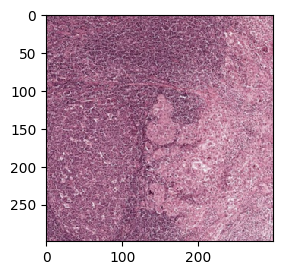

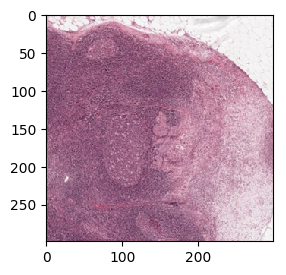

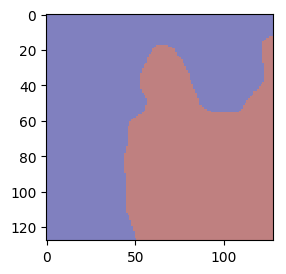

In [0]:
print("tumor size before oversampling: ",len(tumor_patch))
print("normal size: ",len(normal_patch))
plt.figure(figsize=(3, 3), dpi=100)
plt.imshow(tumor_patch[1])
plt.figure(figsize=(3, 3), dpi=100)
plt.imshow(second_level_tumor[1])
plt.figure(figsize=(3, 3), dpi=100)
plt.imshow(tumor_mask_patch[1],cmap ='jet', alpha = 0.5)


In [0]:
train_X=np.concatenate((tumor_patch, normal_patch), axis=0)


In [0]:
print(train_X.shape)

In [0]:
# oversampling with factor
over_multiple = 4
train_tumor = tumor_patch
train_tumor_second = second_level_tumor
train_normal = normal_patch
train_normal_second = second_level_normal
'''
for i in range(over_multiple):
   train_tumor.extend(tumor_patch)
'''

#generate y label
tumor_label = np.array([1]*len(train_tumor)).reshape(len(train_tumor),1)
normal_label = np.array([0]*len(train_normal)).reshape(len(train_normal),1)

print("size of cancerous patches dataset: ", len(train_tumor))
#print(normal_label)
print("size of Non-cancerous patches data: ", len(train_normal))

In [0]:
# split train, validation and test set and randomly permute the data

train_X = np.concatenate((train_tumor,train_normal),axis = 0)
train_Y = np.concatenate((tumor_label,normal_label),axis = 0)
train_second=np.concatenate((train_tumor_second,train_normal_second),axis = 0)

In [0]:
from numpy.random import permutation

#shuffle data
per = permutation(train_X.shape[0])
train_X = train_X[per]
train_Y = train_Y[per]
train_second = train_second[per]

In [0]:
#data for model2 which is from two scales
input_X = []
input_X.append(train_X)
input_X.append(train_second)
print(train_X.shape)
print(train_Y.shape)

(4688, 299, 299, 3)
(4688, 1)


##Step3: Build multi-scale model

In [0]:
#model for multi-scale data


from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate




base1 = InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299, 3))
base1.trainable = False
for layer in base1.layers:
    layer.name = layer.name + '_1'
    layer.trainable = False
base2 = InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299, 3))
base2.trainable = False
for layer in base2.layers:
    layer.name = layer.name + '_2'
    layer.trainable = False

x1 = base1.output
x1_output = Flatten()(x1)

x2 = base2.output
x2_output = Flatten()(x2)

output1 = concatenate([x1_output, x2_output])
output2 = Dense(64, activation='relu')(output1)
final_output = Dense(1, activation='sigmoid')(output2)

model = Model(inputs=[base1.input, base2.input], outputs=final_output)
model.load_weights("/content/gdrive/My Drive/Colab Notebooks/model1.h5")



Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 1s 0us/step


In [0]:
from tensorflow.keras import optimizers
rms = optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer=rms,
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_X, train_Y,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1
                    )

model.save_weights("/content/model1.h5")

Train on 4219 samples, validate on 469 samples
Epoch 1/10
4219/4219 [==============================] - 31s 7ms/sample - loss: 2.3482 - acc: 0.6466 - val_loss: 0.5450 - val_acc: 0.7207
Epoch 2/10
4219/4219 [==============================] - 28s 7ms/sample - loss: 0.7031 - acc: 0.7305 - val_loss: 0.6193 - val_acc: 0.7249
Epoch 3/10
4219/4219 [==============================] - 27s 6ms/sample - loss: 0.5183 - acc: 0.7763 - val_loss: 0.5101 - val_acc: 0.7697
Epoch 4/10
4219/4219 [==============================] - 27s 6ms/sample - loss: 0.4536 - acc: 0.8144 - val_loss: 0.4337 - val_acc: 0.8038
Epoch 5/10
4219/4219 [==============================] - 27s 6ms/sample - loss: 0.3774 - acc: 0.8597 - val_loss: 0.4606 - val_acc: 0.8038
Epoch 6/10
4219/4219 [==============================] - 27s 6ms/sample - loss: 0.2994 - acc: 0.8848 - val_loss: 0.5467 - val_acc: 0.7825
Epoch 7/10
4219/4219 [==============================] - 27s 6ms/sample - loss: 0.2335 - acc: 0.9080 - val_loss: 0.4475 - val_acc: 0

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# plot the accracy
epochs = range(len(acc))

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, color='blue', label='Train')
plt.plot(epochs, val_acc, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

_ = plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, color='blue', label='Train')
plt.plot(epochs, val_loss, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

##Step4: Test and heat map

In [0]:
#generate test dataset
import random
patch_size = 299
threshold = 0.3*299*299
central_size = 128
base_level = 4
stride = 100
tumor_test = []
normal_test = []
second_tumor_test = []
second_normal_test = []
for k in [17,18]:
  for i in range(patch_size+1,slides[k].level_dimensions[4][0]-patch_size, stride): 
    for j in range(patch_size+1,slides[k].level_dimensions[4][1]-patch_size,stride):
      curr_patch = extract_patch(slides[k], i, j, base_level, patch_size, patch_size)
      #find ratio of tissue region to discard invalid patch
      tissue_pixel = find_tissue_pixels(curr_patch)
      valid_size=len(list(tissue_pixel))
      if valid_size > threshold:
        #add patch mask to data set
        second_level_patch = extract_patch(slides[k], i/2, j/2, base_level+1, patch_size, patch_size)
        mask_region = extract_patch(tumor_masks[k], i, j, base_level, central_size, central_size)
        mask_region = mask_region[:,:,0]
        if isTumor(mask_region):
          tumor_test.append(curr_patch)
          second_tumor_test.append(second_level_patch)
        else:
          if random.random()<0.25:
            normal_test.append(curr_patch)
            second_normal_test.append(second_level_patch)

            
            

In [0]:
tumor_tlabel = [1]*len(tumor_test)
normal_tlabel = [0]*len(normal_test)
first_X = np.concatenate((tumor_test,normal_test),axis = 0)
test_Y = np.concatenate((tumor_tlabel,normal_tlabel),axis = 0)
second_X = np.concatenate((second_tumor_test,second_normal_test),axis = 0)
test_X = []
test_X.append(first_X)
test_X.append(second_X)

In [0]:
test_loss, test_acc = model.evaluate(test_X,test_Y)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

160/160 [==============================] - 1s 5ms/sample - loss: 0.4467 - acc: 0.8188
Test loss: 0.44666642546653745
Test accuracy: 0.81875


In [0]:
#heat map generation
def fill_mask(mask,x,y,pred):
  mask[y][x] = pred
  

def slevel_eval(k):
  patch_size = 299
  threshold = 0.3*299*299
  central_size = 128
  stride = 128
  base_level = 4
  pmask = np.zeros((slides[k].level_dimensions[4][1],slides[k].level_dimensions[4][0]))
  for i in range(patch_size+1,slides[k].level_dimensions[4][0]-patch_size, stride): 
    for j in range(patch_size+1,slides[k].level_dimensions[4][1]-patch_size,stride):
      curr_patch = extract_patch(slides[k], i, j, base_level, patch_size, patch_size)
      #find ratio of tissue region to discard invalid patch
      tissue_pixel = find_tissue_pixels(curr_patch)
      valid_size=len(list(tissue_pixel))
      
      if valid_size > threshold:
        second_level_patch = extract_patch(slides[k], i/2, j/2, base_level+1, patch_size, patch_size)
        input_x = []
        input_x.append(np.array([curr_patch.tolist()]))
        input_x.append(np.array([second_level_patch.tolist()]))
        pred = model.predict(input_x)
        for m in range(i-patch_size//2,i+patch_size//2):
          for n in range(j-patch_size//2, j+patch_size//2):
            fill_mask(pmask,m,n,pred)
        

  print("slide ", k , " predicted")
  return pmask


test_slide = read_slide(slides[20], 
                         x=0, 
                         y=0, 
                         level=4, 
                         width=slides[20].level_dimensions[4][0], 
                         height=slides[20].level_dimensions[4][1])
test_mask = read_slide(tumor_masks[20], 
                         x=0, 
                         y=0, 
                         level=4, 
                         width=tumor_masks[20].level_dimensions[4][0], 
                         height=tumor_masks[20].level_dimensions[4][1])
predict_mask = slevel_eval(20)


slide  20  predicted


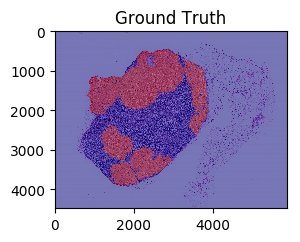

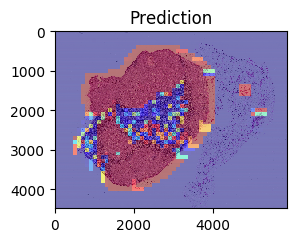

In [0]:
test_mask = read_slide(tumor_masks[20], 
                         x=0, 
                         y=0, 
                         level=4, 
                         width=tumor_masks[20].level_dimensions[4][0], 
                         height=tumor_masks[20].level_dimensions[4][1])
plt.figure(figsize=(3, 3), dpi=100)
plt.title("Ground Truth")
plt.imshow(test_slide)
plt.imshow(test_mask[:,:,0],cmap ='jet', alpha = 0.5)

plt.figure(figsize=(3, 3), dpi=100)
plt.title("Prediction")
plt.imshow(test_slide)
plt.imshow(predict_mask,cmap ='jet', alpha = 0.5)

In [0]:
print(slides[20].level_dimensions[4][0])
print(predict_mask.shape)

5888
(5888, 4480)


##Step5: Evaluation, ROC

In [0]:
from sklearn.metrics import roc_curve, auc
y_test = []
y_test = model.predict(test_X)


In [0]:
y_test = y_test[:,0]
print(y_test)

[2.58217156e-02 4.65361297e-01 9.35011625e-01 3.83736253e-01
 6.37900829e-03 9.99131083e-01 8.21095705e-01 9.94155586e-01
 6.07177615e-01 9.97477293e-01 1.13692582e-02 5.11387110e-01
 9.48581696e-01 2.73096561e-03 9.29731011e-01 8.54613423e-01
 3.87227297e-01 8.82220566e-02 4.45005298e-03 5.51406026e-01
 5.00510156e-01 1.26585364e-03 5.76115489e-01 9.84240770e-01
 6.06572509e-01 1.84309483e-02 1.63828045e-01 9.10496950e-01
 1.63504153e-01 3.16431522e-02 4.04405594e-03 3.06901336e-03
 6.81361556e-03 3.18795443e-04 6.85453415e-06 1.31269097e-02
 2.91031599e-03 8.83774340e-01 3.34563851e-03 6.08906150e-03
 5.30817449e-01 1.54055059e-02 2.21133232e-05 1.52781725e-01
 5.27628481e-01 9.55722332e-01 2.29477882e-05 7.16745973e-01
 6.80248618e-01 1.62518024e-03 9.78502929e-02 1.21712685e-04
 1.38350725e-02 2.43527174e-01 0.00000000e+00 2.93949485e-01
 4.19020653e-05 2.14576721e-06 3.00171971e-03 0.00000000e+00
 9.62484479e-02 6.38961792e-05 3.38578224e-03 1.22070312e-04
 1.02522969e-02 2.275467

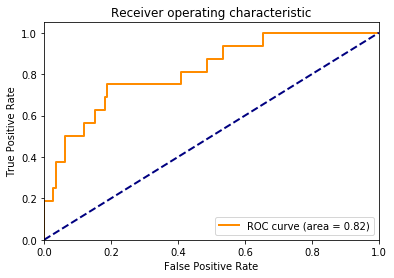

In [0]:
#test_y = test_Y.reshape(160).tolist()
fpr, tpr, _ = roc_curve(test_y, y_test)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()